In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.models import resnet34
from torchvision.transforms import ToTensor
from transformers import BertModel, BertTokenizer
from torchvision import transforms
from PIL import Image

class TextEncoder(nn.Module):
    def __init__(self, max_length=30):
        super(TextEncoder, self).__init__()
        # Text feature extraction module (BERT)
        # Load the pretrained BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.bert_model = self.bert_model.to("cuda:0")
        self.max_length = max_length

        self.gru = nn.GRU(
            input_size=768, hidden_size=256, bidirectional=True, batch_first=True
        )
        self.gru = self.gru.to("cuda:0")

    def forward(self, tokenized_statements):
        # Get BERT embeddings for the input statements
        with torch.no_grad():
            outputs = self.bert_model(tokenized_statements)

        # Extract word vectors
        word_vectors = outputs.last_hidden_state

        # Forward pass through the GRU
        text_embeddings, _ = self.gru(word_vectors)

        return text_embeddings


# Define the ProjectionHead class
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=512,  # Update the projection dimension
        dropout=0.1,
    ):
        super(ProjectionHead, self).__init__()  # Correct usage of super()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected  # skip connection
        x = self.layer_norm(x)  # Layer Normalization
        return x


# Cross-Attention module
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.multihead_atten = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, image_features, text_features):
        key = text_features
        value = text_features
        query = image_features
        attn_output, attn_output_weights = self.multihead_atten(query, key, value)

        return attn_output, attn_output_weights


def cosine_similarity(attn_out, text_embed):
    # Create a 4x4 similarity matrix
    dim = len(attn_out)
    similarity_matrix = torch.zeros(dim, dim)

    for i in range(dim):
        for j in range(dim):
            similarity = F.cosine_similarity(attn_out[i], text_embed[j], dim=0)
            similarity_matrix[i, j] = similarity

    # Print the similarity matrix
    return similarity_matrix


class DOGS(nn.Module):
    def __init__(self, embedding_dim=512):
        super(DOGS, self).__init__()

        # Image feature extraction module (ResNet152)
        self.image_encoder = models.resnet50(pretrained=True)
        # self.image_encoder = self.image_encoder.to('cuda:0')  # Move the ResNet model to GPU

        self.image_encoder = nn.Sequential(*list(self.image_encoder.children())[:-2])
        # self.image_encoder = self.image_encoder.to('cuda:0')  # Move the ResNet model to GPU

        self.text_encoder = TextEncoder(max_length=30)
        self.projection_head = ProjectionHead(2048, projection_dim=512, dropout=0.1)
        # Cross-attention module
        self.cross_attention = CrossAttentionLayer(embedding_dim, num_heads=4)

    def forward(self, images, statements):
        # Image feature extraction
        image_features = self.image_encoder(images)
        image_embedding = image_features.squeeze(0)

        text_embeddings = self.text_encoder(statements)
        text_embed = text_embeddings.permute(1, 0, 2)

        # flatten the kernel features
        image_embedding = image_embedding.view(len(image_embedding), 2048, 49)
        # reshape the image embedding [num_region, batch_size, embed_dim]
        image_embedding = image_embedding.permute(0, 2, 1)
        image_embedding = self.projection_head(image_embedding)
        image_embedding = image_embedding.permute(1, 0, 2)

        # Cross-attention
        attn_output, attn_output_weights = self.cross_attention(
            image_embedding, text_embed
        )

        # Perform average pooling
        avg_attn_output = torch.mean(attn_output, dim=0)
        # Perform average pooling
        avg_text_embeddings = torch.mean(text_embeddings, dim=1)

        score = cosine_similarity(avg_attn_output, avg_text_embeddings)

        return score, avg_attn_output, attn_output,attn_output_weights


class ContrastiveLoss(nn.Module):
    """
    Compute contrastive loss
    """

    def __init__(self, margin=0, max_violation=False):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.max_violation = max_violation

    def forward(self, scores):
        diagonal = scores.diag()
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        # compare every diagonal score to scores in its column
        # caption retrieval
        cost_s = (self.margin + scores - d1).clamp(min=0)
        # compare every diagonal score to scores in its row
        # image retrieval
        cost_im = (self.margin + scores - d2).clamp(min=0)

        return cost_s.sum() + cost_im.sum()

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Check if GPU is available
if torch.cuda.is_available():
    # Create your model
    model = DOGS()
    # Move the model to the GPU
    model = model.to(
        "cuda:0"
    )  # You can also use model.to('cuda:0') for a specific GPU index

    for param in model.parameters():
        param.to("cuda:0")
    # Alternatively, you can use the .cuda() method
    # model = model.cuda()
else:
    model = DOGS()
    print("GPU is not available. Using CPU.")

# Count the learnable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total learnable parameters: {total_params}")

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.8MB/s]


Total learnable parameters: 136929600


In [ ]:

# Create an instance of your model
image_captioning_model = model
model_path = '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/model_epoch_10.pt'
image_captioning_model.load_state_dict(torch.load(model_path, map_location='cpu'))
image_captioning_model.eval()


DOGS(
  (image_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
#Inference for batch of 4 image text pair
from transformers import BertTokenizer
statements = ["Dog sit on grass land", "cat sit on bed", "aeroplane fly in the sky", "house"]
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_statements = [
    tokenizer.encode(
        statement,
        add_special_tokens=True,
        padding="max_length",
        max_length=30,
        truncation=True,
        return_tensors="pt"
    )
    for statement in statements
]

# Define image preprocessing transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_paths = ['/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/dog.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/cat.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/aeroplane.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/house.jpg']
images = []

for image_path in image_paths:
    image = Image.open(image_path)
    image = image_transform(image)
    images.append(image)

# Stack the images into a single tensor
images = torch.stack(images)

images = images.to("cuda:0")
tokenized_statements = [tokenized_statement.to("cuda:0") for tokenized_statement in tokenized_statements]
print(images.shape)
tokenized_statements = torch.stack(tokenized_statements)
reshaped_tokenized_statements = tokenized_statements.squeeze(1)
print(reshaped_tokenized_statements.shape)
# Make predictions
with torch.no_grad():
    output = image_captioning_model(images, reshaped_tokenized_statements)

# Process and print the results
print(output)


torch.Size([4, 3, 224, 224])
torch.Size([4, 30])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


(tensor([[0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7691, 0.7090]]), tensor([[ 4.3563e+04,  3.8820e+04,  4.1835e+04,  ..., -4.0933e+02,
         -2.7256e+01, -4.3672e+04],
        [ 4.3561e+04,  3.8819e+04,  4.1834e+04,  ..., -4.0935e+02,
         -2.7239e+01, -4.3670e+04],
        [ 4.3563e+04,  3.8821e+04,  4.1835e+04,  ..., -4.0932e+02,
         -2.7258e+01, -4.3672e+04],
        [ 4.3970e+04,  3.9183e+04,  4.2235e+04,  ..., -4.1342e+02,
         -2.4930e+01, -4.4078e+04]], device='cuda:0'), tensor([[[ 4.3563e+04,  3.8820e+04,  4.1835e+04,  ..., -4.0933e+02,
          -2.7256e+01, -4.3672e+04],
         [ 4.3561e+04,  3.8819e+04,  4.1834e+04,  ..., -4.0935e+02,
          -2.7239e+01, -4.3670e+04],
         [ 4.3563e+04,  3.8821e+04,  4.1835e+04,  ..., -4.0932e+02,
          -2.7258e+01, -4.3672e+04],
         [ 4.3970e+04,  3.9183e+04,  4.2235e+04,  ..., -4.1342e+02,
          -2.49

In [ ]:
output[0].shape #cosine similarity between batch of 4 images-text pair

torch.Size([4, 4])

In [ ]:
output[1].shape #(4,49,512) output from cross attention is converted with average pooling outputs (4,512)

torch.Size([4, 512])

In [ ]:
output[0] #cross attention cosine similarity output

tensor([[0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7692, 0.7089],
        [0.7583, 0.7468, 0.7691, 0.7090]])

In [ ]:
output[2].shape

torch.Size([49, 4, 512])

In [ ]:
reshaped_tensor = output[2].permute(1, 0, 2)
reshaped_tensor.shape

torch.Size([4, 49, 512])

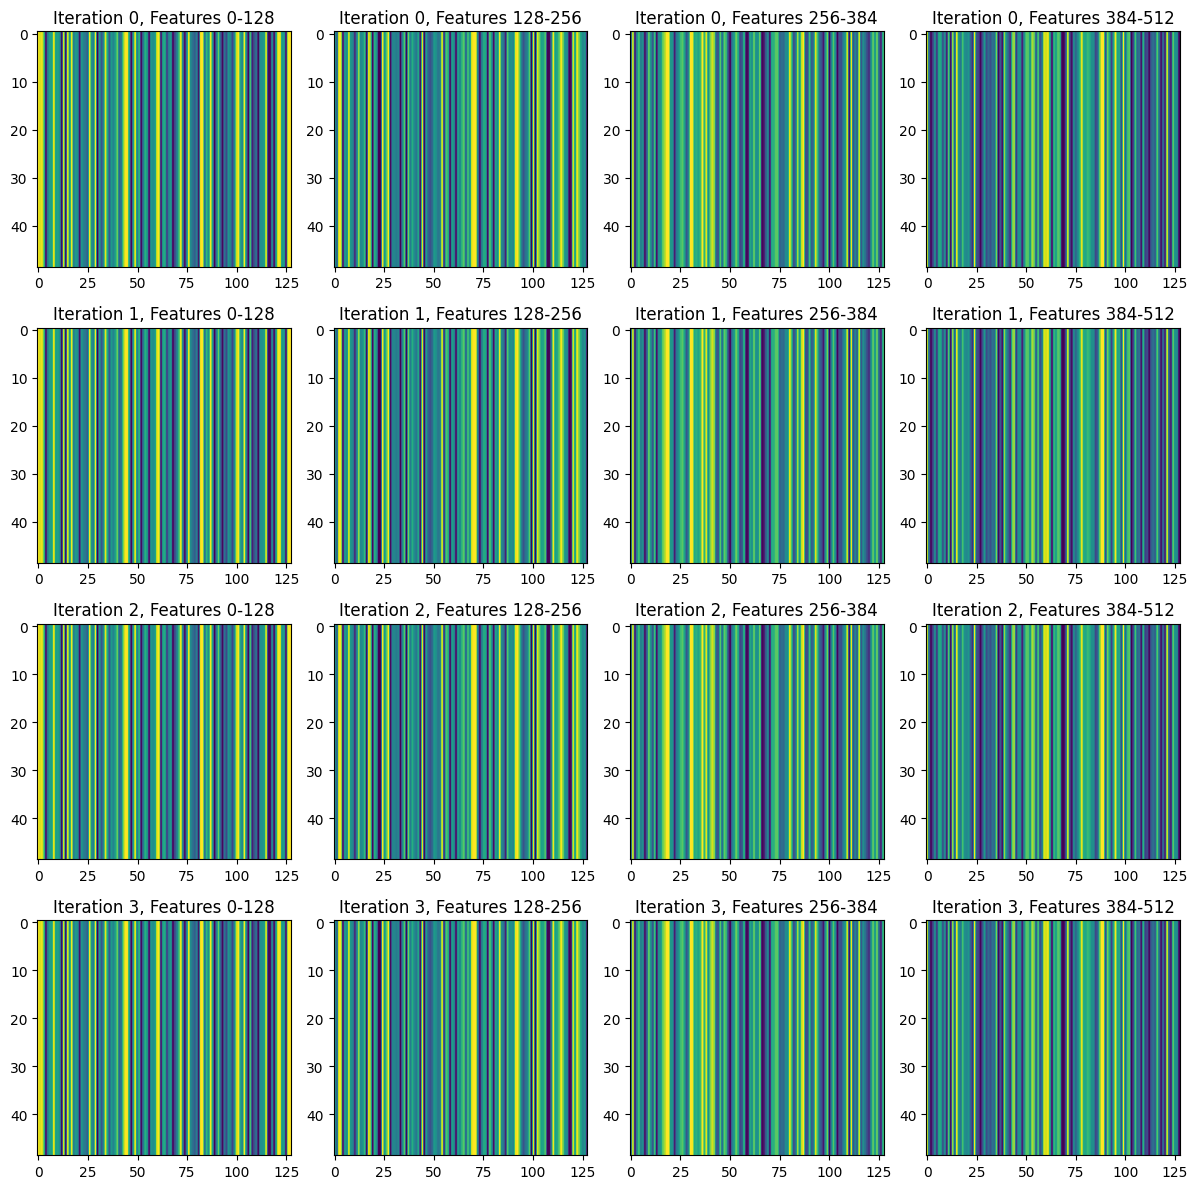

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming you have an output tensor with shape [4, 49, 512]
output_tensor = reshaped_tensor.cpu()

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Iterate over the first dimension (4) for each subplot row
for i in range(4):
    # Iterate over the second dimension (49) for each subplot column
    for j in range(4):
        # Select the data for the current iteration
        data = output_tensor[i, :, j * 128:(j + 1) * 128]  # For example, display 128 features at a time

        # Create a plot for the data
        axs[i, j].imshow(data, aspect='auto', cmap='viridis')
        axs[i, j].set_title(f"Iteration {i}, Features {j*128}-{(j+1)*128}")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


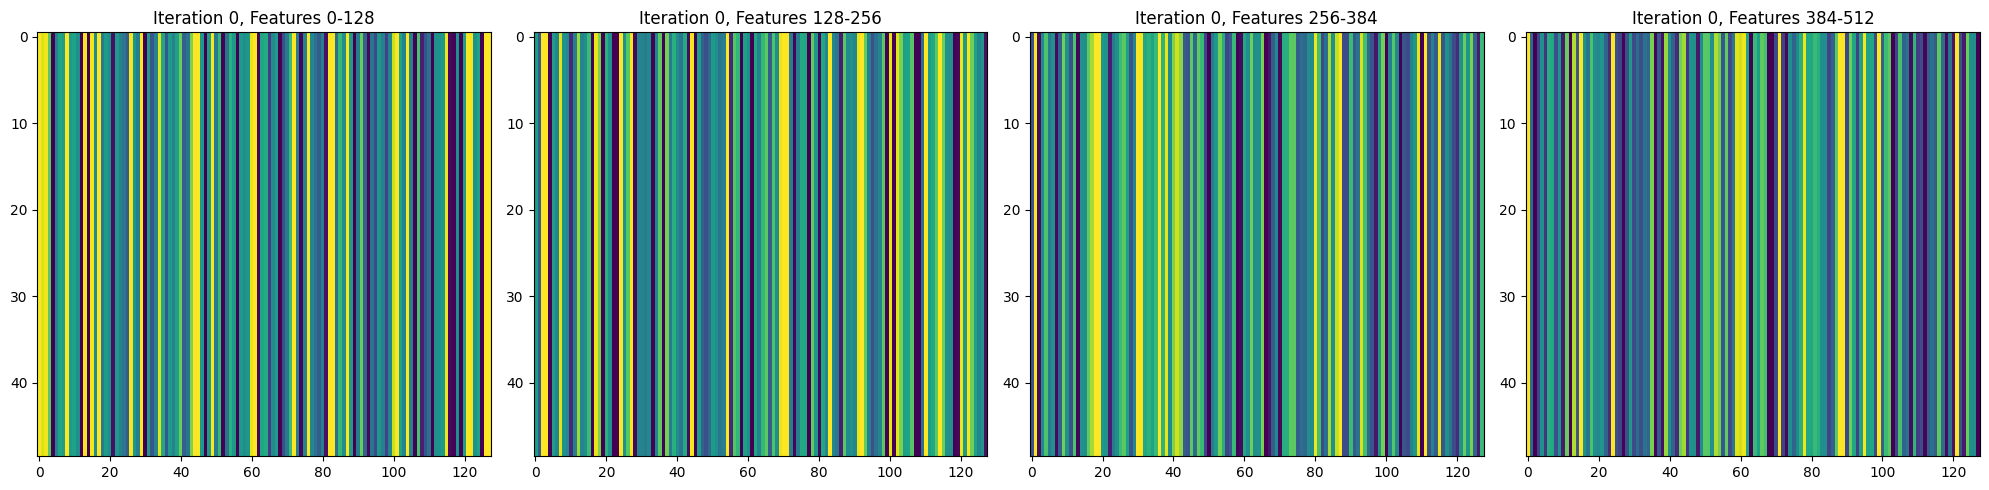

In [ ]:
# Create a plot for the first image mapping
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterate over the second dimension (49) for each subplot column
i = 0
for j in range(4):
    # Select the data for the current iteration
    data = output_tensor[i, :, j * 128:(j + 1) * 128]  # For example, display 128 features at a time

    # Create a plot for the data
    axs[j].imshow(data, aspect='auto', cmap='viridis')
    axs[j].set_title(f"Iteration {i}, Features {j*128}-{(j+1)*128}")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
reshaped_tensor[0].shape

torch.Size([49, 512])

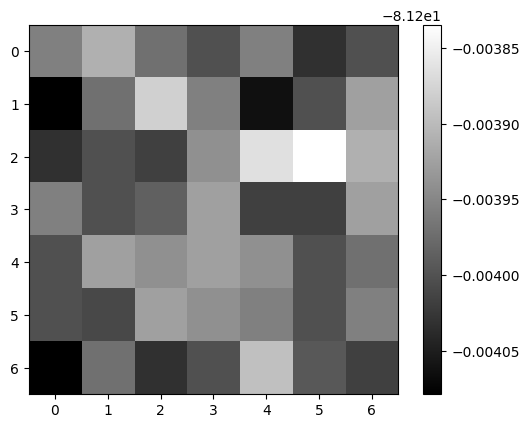

In [ ]:
import torch
import matplotlib.pyplot as plt

reshaped_tensor1 = reshaped_tensor[0].cpu()

# Reshape from (49, 512) to (7, 7, 512)
reshaped_tensor2 = reshaped_tensor1.view(7, 7, 512)

# Reduce the 512 dimensions to a single value by averaging
output_tensor = reshaped_tensor2.mean(dim=2)  # Now it's (7, 7)

# Create a single cmap with (7, 7) grid
plt.imshow(output_tensor, cmap='gray', interpolation='none')
plt.colorbar()

# Show the plot
plt.show()


In [ ]:
attn_mapping = output[3]

In [ ]:
attn_mapping[0].shape

torch.Size([49, 30])

In [ ]:
statements[0]

'Dog sit on grass land'

In [ ]:
tokenized_statements[0]

tensor([[ 101, 3899, 4133, 2006, 5568, 2455,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]], device='cuda:0')

torch.Size([30, 7, 7])


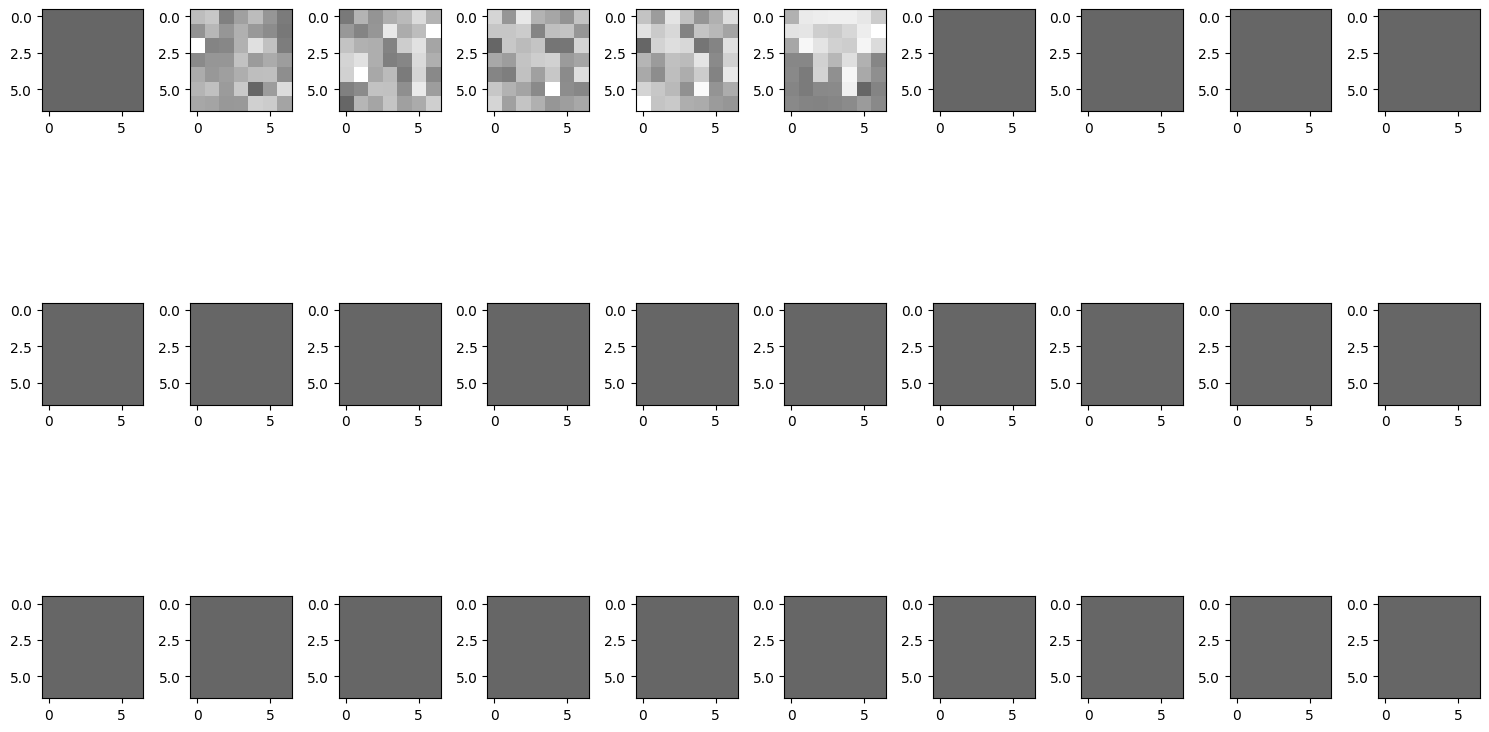

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming attn_maps is a PyTorch tensor with shape [ 30,7,7]
attn_sc = attn_mapping[0].cpu()
attn_maps = attn_sc.permute(1,0)
# Reshape attn_maps to [30,(7, 7)]
attn_maps = attn_maps.view(30, 7, 7)

def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 30
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 3)), 3)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()

plot_attention_maps(attn_maps)
plt.show()


cat sit on bed
tensor([[ 101, 4937, 4133, 2006, 2793,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]], device='cuda:0')


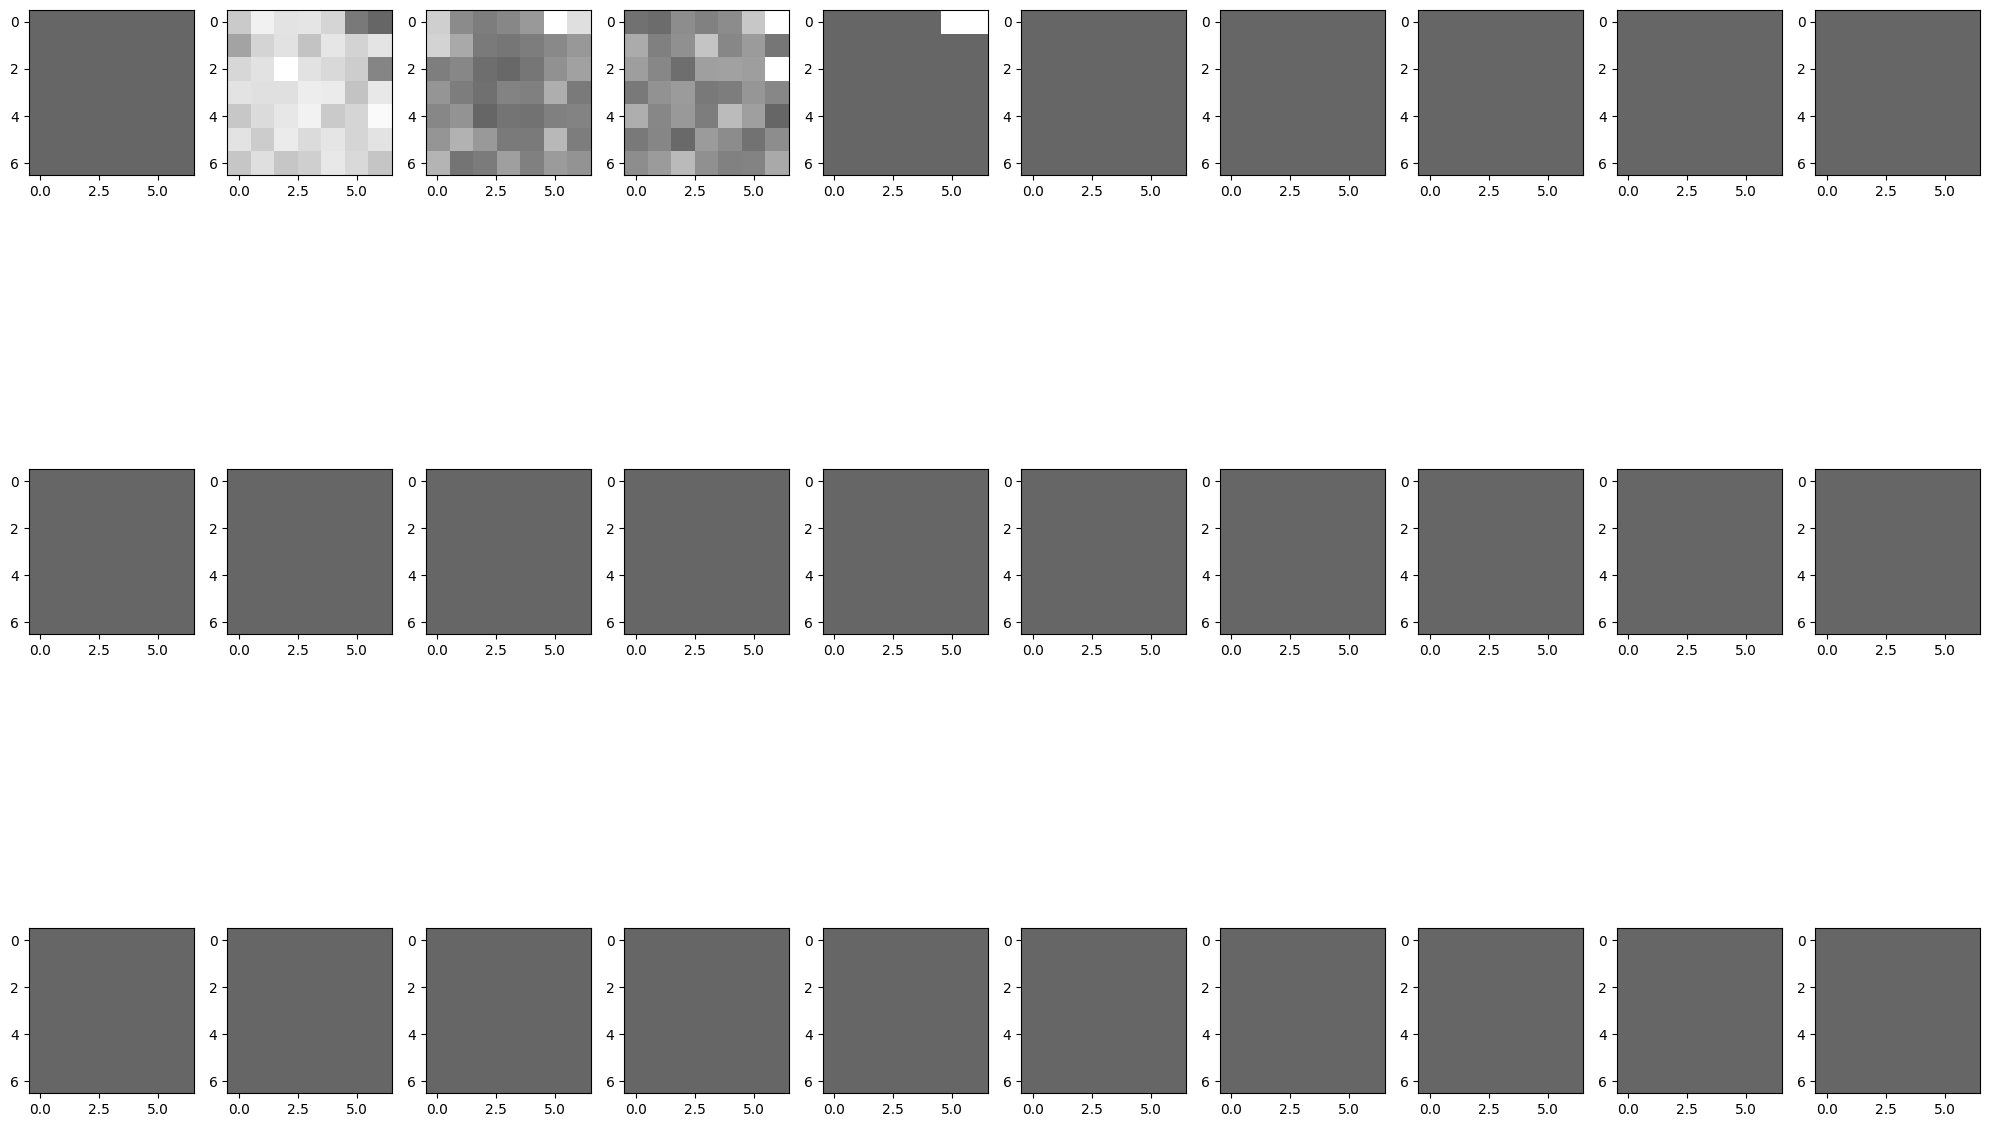

In [ ]:
print(statements[1])
print(tokenized_statements[1])
attn_sc = attn_mapping[1].cpu()
attn_maps = attn_sc.permute(1,0)
attn_maps = attn_maps.view(30, 7, 7)
plot_attention_maps(attn_maps)
plt.show()

aeroplane fly in the sky
tensor([[  101, 18440, 11751,  4875,  1999,  1996,  3712,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')


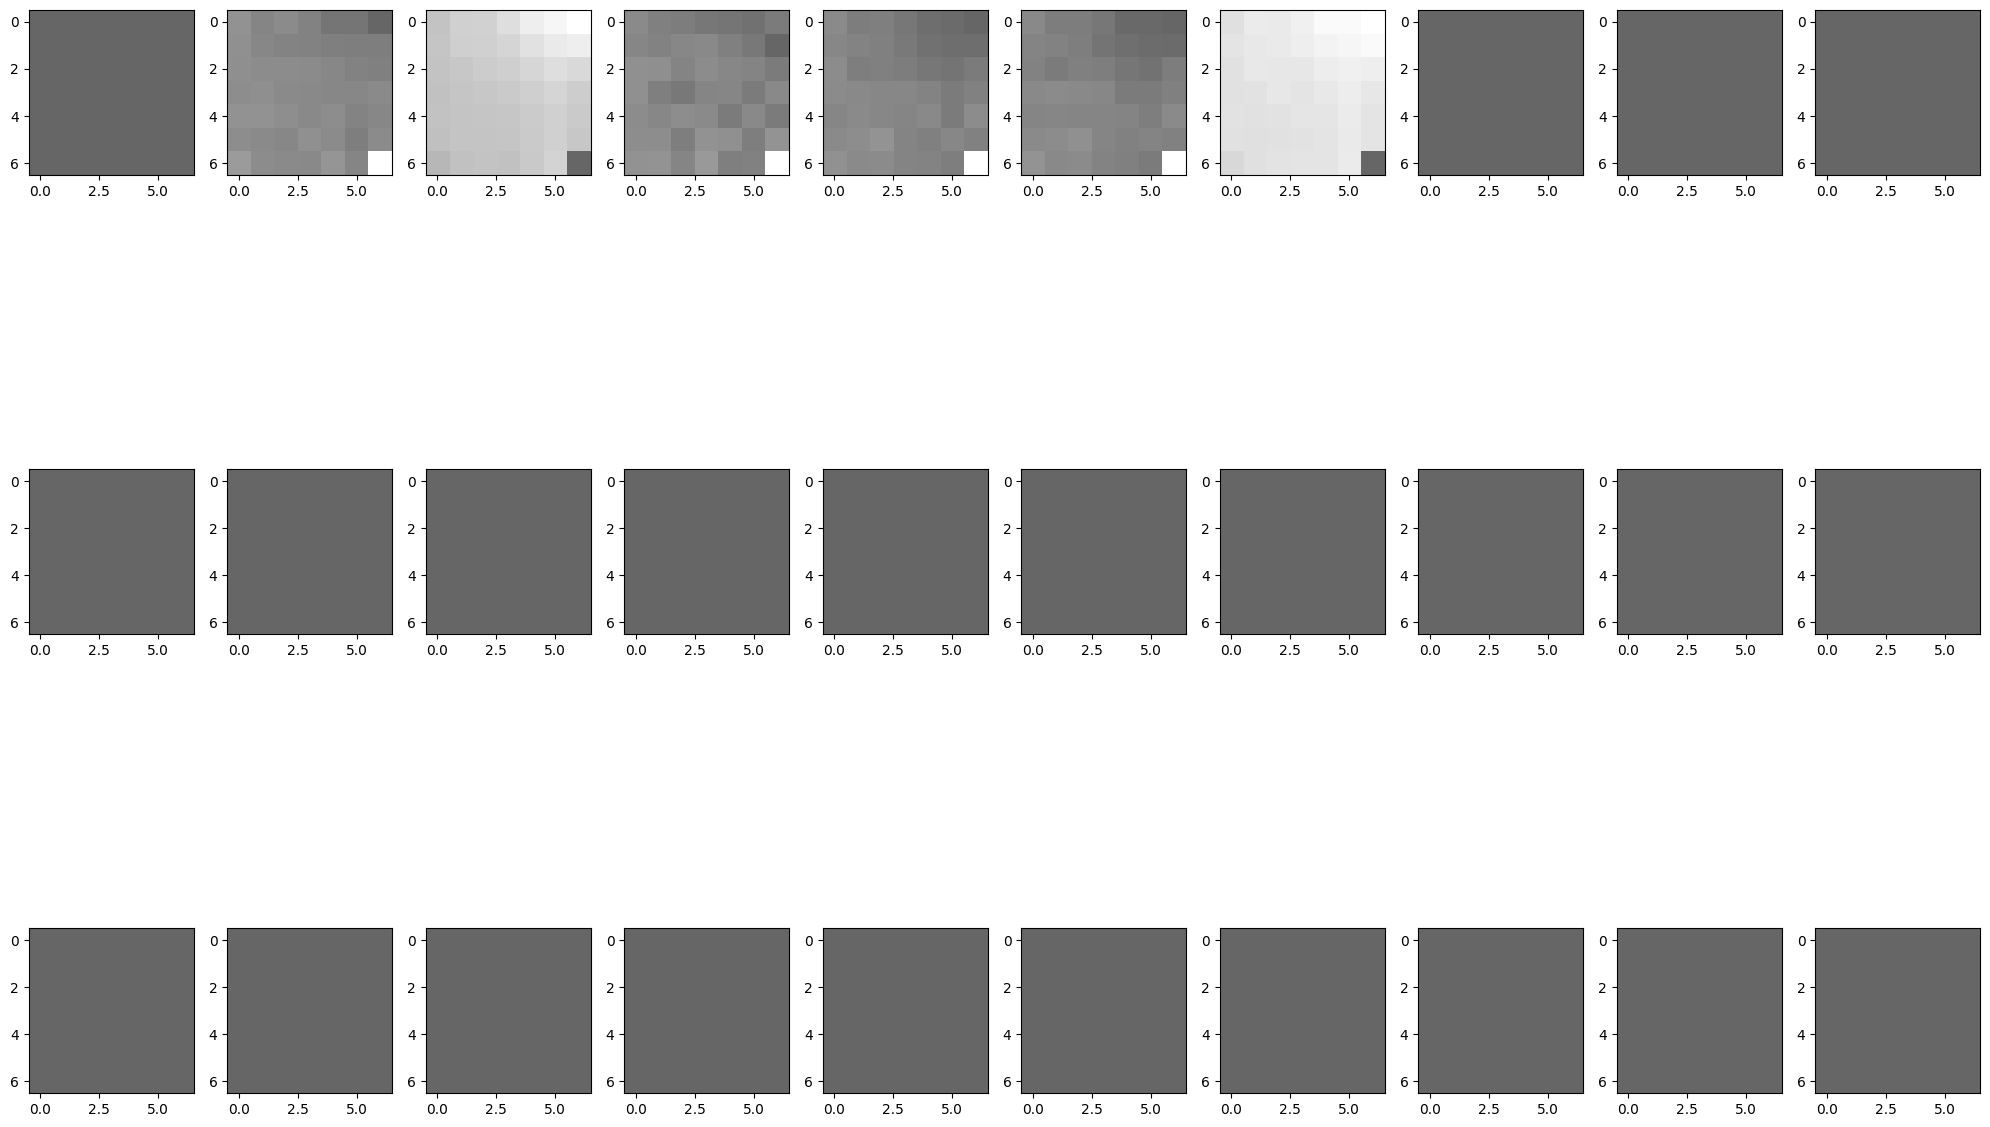

In [ ]:
print(statements[2])
print(tokenized_statements[2])
attn_sc = attn_mapping[2].cpu()
attn_maps = attn_sc.permute(1,0)
attn_maps = attn_maps.view(30, 7, 7)
plot_attention_maps(attn_maps)
plt.show()

house
tensor([[ 101, 2160,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]], device='cuda:0')


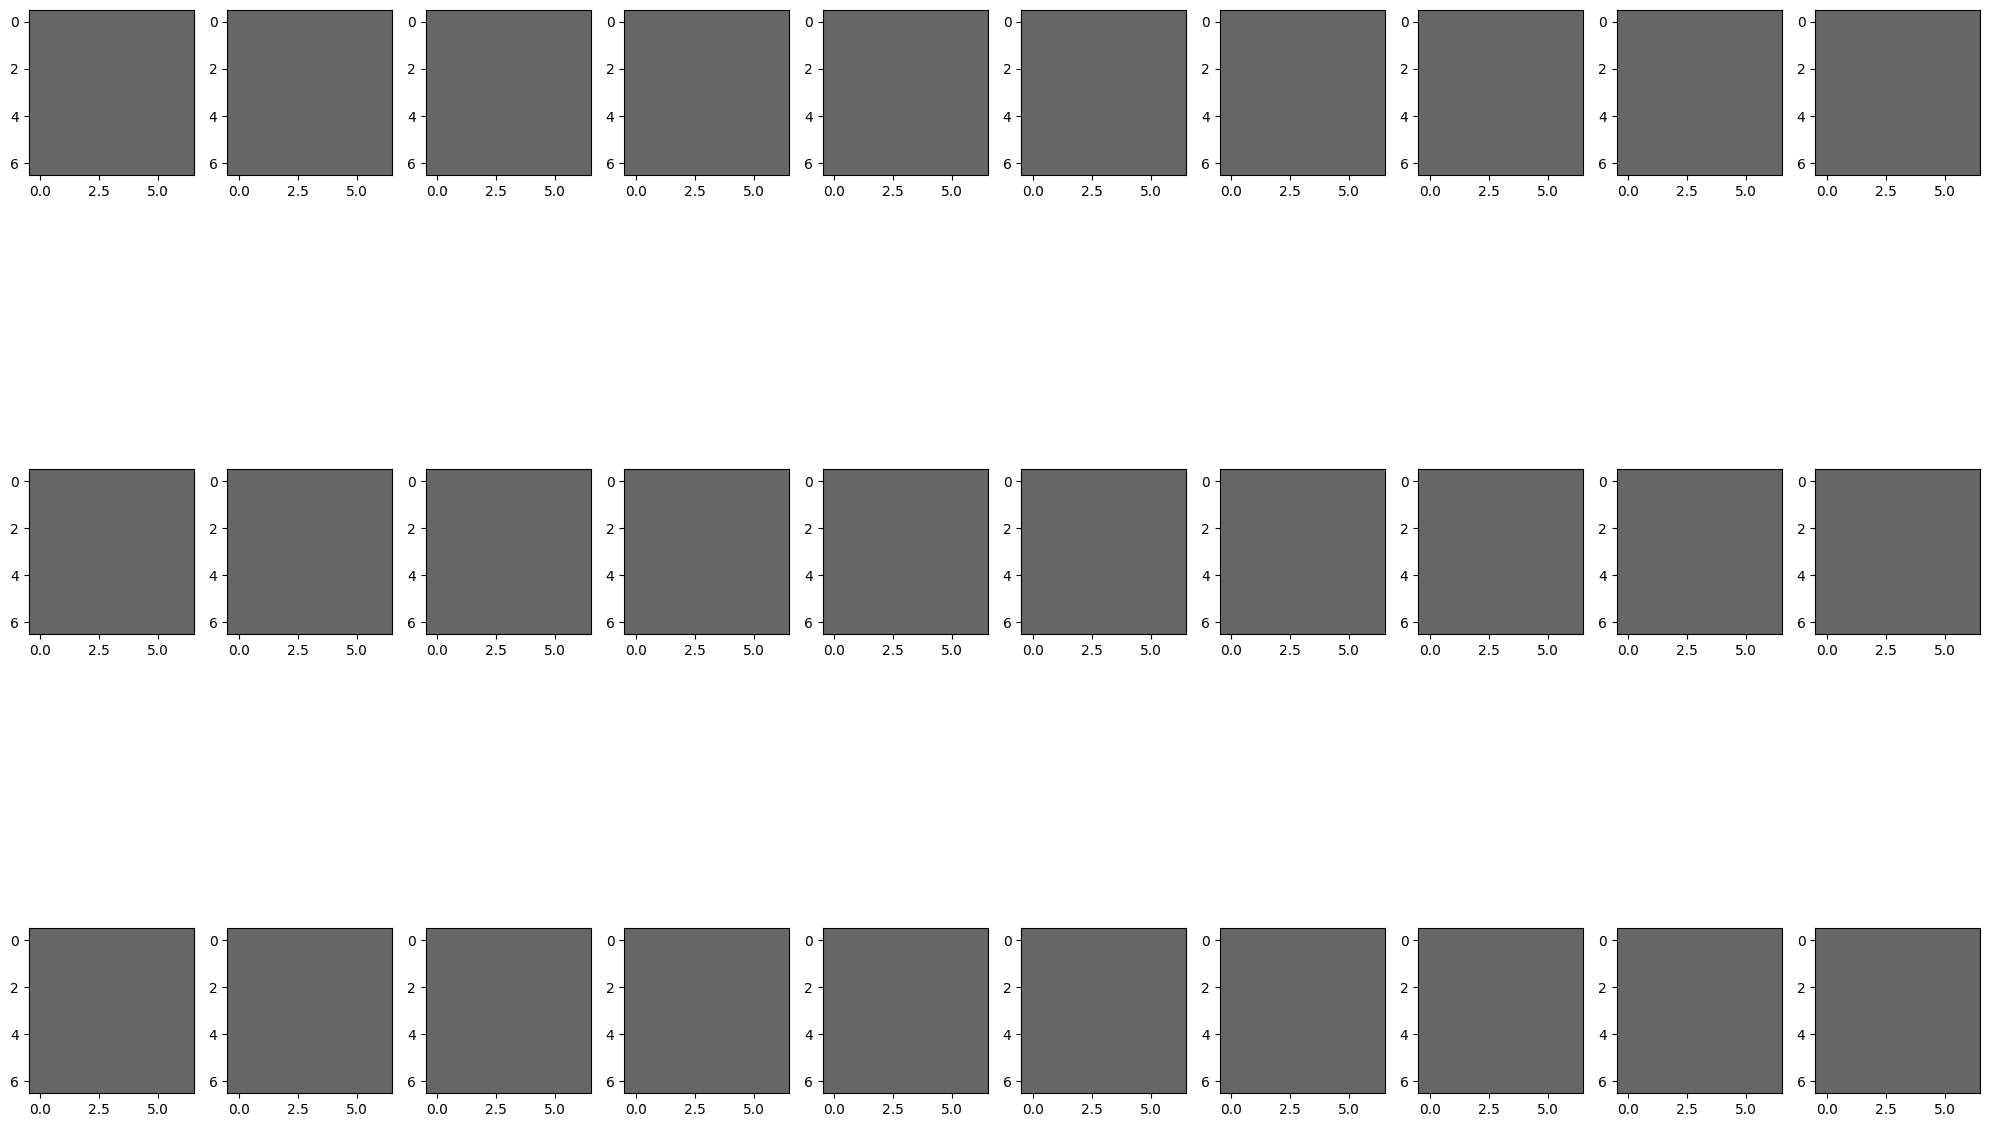

In [ ]:
print(statements[3])
print(tokenized_statements[3])
attn_sc = attn_mapping[3].cpu()
attn_maps = attn_sc.permute(1,0)
attn_maps = attn_maps.view(30, 7, 7)
plot_attention_maps(attn_maps)
plt.show()

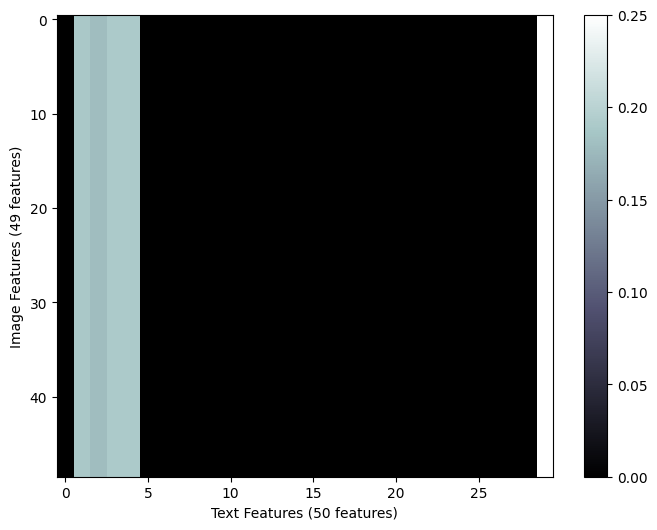

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming attn_maps is a PyTorch tensor with shape [49, 50]
attn_maps = attn_mapping[0].cpu()

# Create a figure
plt.figure(figsize=(8, 6))

# Plot the attention map as a heatmap
plt.imshow(attn_maps, cmap='bone', aspect='auto')

# Add colorbar for reference
plt.colorbar()

# Set labels for the x and y axes
plt.xlabel('Text Features (50 features)')
plt.ylabel('Image Features (49 features)')
# Show the plot
plt.show()


In [ ]:
#Inference for a singe image text pair
from transformers import BertTokenizer
import torch

# Load the test image
test_image_path = '/content/drive/MyDrive/dog.jpg'
image = Image.open(test_image_path)
image = image_transform(image)
image = image.unsqueeze(0)  # Add batch dimension

# Prepare the test caption
test_caption = "Dog sit on grass land"

# Tokenize the caption
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_statement = tokenizer.encode(test_caption, add_special_tokens=True, padding="max_length", max_length=30, truncation=True, return_tensors="pt")

image = image.to("cuda:0")
print(image.shape)
tokenized_statement = tokenized_statement.to("cuda:0")
print(tokenized_statement.shape)
# Make predictions for the single image and text token pair
with torch.no_grad():
    output = image_captioning_model(image, tokenized_statement)

# Process and print the results
print(output)
